# Home Credit - Credit Risk Model Stability Project

## Abstract

The goal of this project is to accurately predict which clients are likely to default on their loans. Loan defaults pose significant financial risks to consumer finance providers, impacting their profitability and stability. Traditional methods of assessing default risk often rely on historical data and conventional credit scoring models, which may not fully capture the complexities of an individual's financial behavior over time. By leveraging advanced machine learning techniques, this project seeks to develop more reliable and robust models for predicting loan defaults.

This endeavor is crucial as it offers consumer finance providers a tool to better assess the risk associated with potential clients, leading to more informed lending decisions. Improved prediction models can help reduce the incidence of loan defaults, thereby enhancing the financial health of lending institutions. Additionally, stable and accurate risk assessments can contribute to fairer lending practices, as they are likely to identify creditworthy clients who might be overlooked by traditional methods. This project not only aims to enhance the accuracy of default predictions but also emphasizes the importance of model stability over time, ensuring that the solutions are sustainable and effective in the long run.

### Accomplishments:

1. Ability to work with highly imbalanced data and perform different types of missing value imputations to enhance model performance:
    A significant discovery during our investigation was the profound impact that missing value imputation had on model performance. Given that approximately 92% of our dataset contained missing values, robust imputation strategies were essential(mean and mode imputation, knn imputation, binary indicators) significantly improved the model's ability to handle incomplete data.
    This approach not only filled the gaps in the dataset but also provided additional signals that the model could leverage to make more accurate predictions.
2. Effectivenes of SMOTE in addressing class imbalance:
    By generating synthetic samples for the minority class, SMOTE significantly improved the recall of the minority class predictions without overly compromising precision. This balancing act was pivotal in ensuring that the model could identify true positives more reliably. Our iterative evaluation showed a substantial increase in the recall metric, indicating that the model became much better at identifying positive instances in the imbalanced dataset.

## Introduction

Our project aims to develop a robust model for predicting loan defaults using a highly imbalanced dataset from a Kaggle competition hosted by Home Credit ([link](https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/overview)). This dataset includes over 1.5 million cases with a binary target variable indicating default (positive class) or no default (negative class). The data spans various financial and socio-economic features, sourced from multiple tables, with a significant imbalance (97% no default, 3% default) and a high percentage of missing values (92%). The primary research question is: Can we create a stable, accurate predictive model that effectively identifies clients likely to default on loans?

### Importance and Research Plan
Predicting loan defaults accurately is crucial for financial institutions as it directly impacts their risk management strategies and financial stability. Improved prediction models can reduce financial losses and help institutions make more informed lending decisions, ultimately contributing to a healthier financial ecosystem.

#### Key Results

Key results include significant improvements in precision and recall metrics by using the LightGBM model. This demonstrates our model’s enhanced ability to identify true positive cases of loan defaults, despite the challenges posed by the dataset's imbalance and missing values.

## Background

Credit risk refers to the potential loss that lenders face when borrowers fail to repay loans or meet contractual obligations. Traditionally, this means the borrower does not make the agreed-upon loan payments, leading to financial loss for the lender. This risk is crucial in the financial industry, especially for banks and lenders, as it directly affects their profitability and sustainability. Assessing credit risk is essential for lenders, including banks and consumer finance companies, as they evaluate the likelihood that a borrower may default on loan obligations. This assessment involves analysing the borrower's financial history, current financial status, and other socio-economic factors. A high credit risk indicates a higher probability of default, potentially resulting in financial losses for the lender due to unpaid loan principal and interest.

#### Current State of Credit Risk Prediction Models
The landscape of credit risk prediction has evolved significantly with the advent of big data, machine learning, and artificial intelligence technologies. Modern credit risk models have become more sophisticated, integrating various data sources and employing advanced algorithms to improve prediction accuracy. Here are some of the state-of-the-art methods and innovations in current credit risk prediction models:

•	***Machine Learning Models:*** Algorithms such as random forests, gradient boosting machines (GBMs), and neural networks have been successful in predicting credit risk by learning complex patterns in data.

•	***Deep Learning Models:*** More complex models, like deep neural networks, have been explored for their ability to process vast amounts of unstructured data, providing insights from data points traditional models might miss.

•	***Alternative Data Sources:*** Modern credit risk models incorporate non-traditional data, such as mobile phone usage, social media activity, and even psychometric tests, to gauge a borrower's creditworthiness, especially useful for those with little to no traditional credit history.


#### Key Features in Credit Risk Prediction

Certain features are particularly indicative of a borrower's likelihood to default, including:

- ***Credit History:*** A borrower's past behaviour with credit, including payment history, credit utilization, and the age of credit accounts.
- ***Income Level and Stability:*** Regular and verifiable income sources are strong indicators of a borrower's ability to repay loans.
- ***Debt-to-Income Ratio:*** This measures how much of a borrower's income is used to service existing debt, indicating the capacity to take on and repay new debt.
- ***Employment Status:*** Employment stability and the nature of a borrower's job can influence their risk profile.
- ***Socio-Economic Factors:*** Factors such as education level, marital status, and homeownership can also play a role in credit risk assessment.


## Data

As stated above, our dataset comes from the Kaggle Competition - Credit Risk Model Stability hosted by Home Credit, an international consumer finance provider. The data can be obtained by downloading from the Kaggle website ([link](https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/data)) or entering the command line (install Kaggle first):
```bash
kaggle competitions download -c home-credit-credit-risk-model-stability
```

The dataset is spread across 17 tables (1 base table + 16 data tables). It is split between training data with over 1.5 million cases, and testing data with 10 cases and no target labels. Our training and testing sets were taken from the training data provided as the test set could not provide us with any evaluation metrics and was too small.

In [172]:
# Directory to raw data
data_root = '../data/raw/csv_files/train'

### Base Table

In [173]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization functions
import utils.viz_tools as viz_tools

warnings.filterwarnings('ignore')

In [174]:
base_table = 'train_base.csv'
base_df = pd.read_csv(os.path.join(data_root, base_table))
base_df['date_decision'] = pd.to_datetime(base_df['date_decision'])

With the base table we can inspect the composition of the classes. A class imbalance of 97-to-3 in favor of the negative case (no default) is a very imbalanced dataset.

In [175]:
# Total cases
n_total = len(base_df)

# Number of negative cases
n_neg = len(base_df[base_df['target'] == 0])

# Number of positive cases
n_pos = len(base_df[base_df['target'] == 1])

print('Number of total cases:', n_total)
print(f'Negative cases: Count - {n_neg}, Percentage - {100*n_neg/n_total:.2f}%')
print(f'Positive cases: Count - {n_pos}, Percentage - {100*n_pos/n_total:.2f}%')

Number of total cases: 1526659
Negative cases: Count - 1478665, Percentage - 96.86%
Positive cases: Count - 47994, Percentage - 3.14%


The base table also contained another very relevant feature, `date_decision`. As we are trying to predict *future* applicant cases, the test set must be taken from the latest decision dates.

The `date_decision` also contains trends on how often cases default.

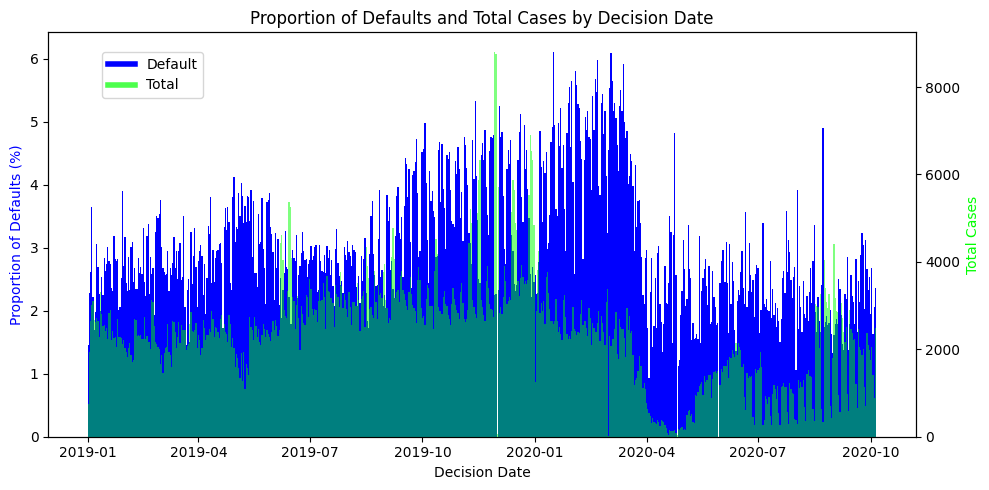

In [176]:
# Get proportion of defaults by date
date_target_prop = base_df.groupby('date_decision')['target'].value_counts(normalize=True).reset_index()
date_target_prop = date_target_prop[date_target_prop['target'] == 1]
date_target_prop['proportion'] = 100 * date_target_prop['proportion']

# Get number of decisions by date
date_total = base_df.groupby('date_decision')['target'].count().reset_index()

# Plot
viz_tools.two_bars_share_x(df1=date_target_prop, df2=date_total,
                          x_name='date_decision', y1_name='proportion',
                          y2_name='target', x_label='Decision Date',
                          title='Proportion of Defaults and Total Cases by Decision Date',
                          y1_label='Proportion of Defaults (%)',
                          y2_label='Total Cases', l1_label='Default',
                          l2_label='Total')

### Data Tables

We have 16 data tables containing static and transactional data stored as categorical data, numerical data, and dates. These tables are further broken down into 3 different depths.

- Depth 0 tables are indexed by the `case_id` alone and primarily include static data such as date of birth.
- Depth 1 tables are indexed by `case_id` and `num_group1` and contain historical data and possible associated parties.
- Depth 2 tables are index by `case_id`, `num_group1`, and `num_group2` while also containing historical data and possible associated parties.

![Tables](figures/tables.jpg)

Of particular note, when `num_group1` is equal to *0*, the data is directly associated with the current applicant of the loan.

In order to predict by case, we needed to aggregate data by `case_id` in the depth 1 and depth 2 tables.

### Data Preprocessing

We separated the data by the current applicant data and non-current applicant data (`num_group1` is not equal to *0*). From there, we applied multiple different aggregations grouping by `case_id`.

- Categorical: we retrieved the mode and applied both binary encoding to reduce the number of columns (versus one-hot encoding) and frequency encoding, to indicate the frequency of the category.
- Numerical: mean, min, max, median, and sum.
- Date: min, max, and number of distinct dates.

![Aggs](figures/aggs.jpg)

From the aggregated data, we decided to subsample the dataset:

- Weight the minority:majority class at a ratio of 10:1.
- Only draw from a subsample that is close to the 
- Additionally, the test set was a holdout of the last cases in the dataset, as stated, in order to get a prediction on *future* cases.

![Sampling](figures/subsample.jpg)

In [177]:
import utils.merge_tools as merge_tools

In [178]:
# Directory to aggregated processed data
data_dir = '../data/processed/grouped/new_aggs/'
base_file = '../data/raw/csv_files/train/train_base.csv'

n_cases = 20000

# Merging all data tables to base table
train_set, test_set = merge_tools.merge_n_case_ids(
    n_ids=n_cases,  # Total cases
    data_dir=data_dir,
    path_to_base=base_file,
    target_weight=10,   # Weight for minority class subsampling
    how_far_back=5, # Size of sample space relative to training size
    test_size=0.2, 
    random_state=28
)

# Drop redundant columns
drop_cols = ['MONTH', 'WEEK_NUM', 'date_decision_right', 'MONTH_right', 'WEEK_NUM_right', 'target_right']
train_set = train_set.drop(columns=drop_cols)
test_set = test_set.drop(columns=drop_cols)

# Sort cases by decision date in train set
train_set = train_set.sort_values('date_decision')

We have a train/test ratio of 4:1.

In [179]:
print('Size of training set:', len(train_set))
print('Size of testing set:', len(test_set))

Size of training set: 16000
Size of testing set: 4000


In [180]:
pct_null = train_set.isnull().sum().sum() / (len(train_set)*(len(train_set.columns)-1))
print(f'Percentage of missing values in aggregated data: {100*pct_null:.2f}%')

Percentage of missing values in aggregated data: 55.74%


The proportion of classes in the training set:

In [181]:
train_set['target'].value_counts(normalize=True)

target
0    0.757062
1    0.242938
Name: proportion, dtype: float64

The proportion of classes in the testing set:

In [182]:
test_set['target'].value_counts(normalize=True)

target
0    0.97775
1    0.02225
Name: proportion, dtype: float64

### Extra data cleaning

We futher clean the data to be able to feed the previously stated predictors.
 - Boolean Columns:
The boolean columns are filled with False where None is present, and then converted to boolean type using .astype(bool).
- Object Columns:
The object columns, which contain None, True, or False, are replaced with np.nan, 1.0, or 0.0 respectively, and converted to float.

In [183]:
# Convert date_decision to timestamp
train_set['date_decision'] = pd.to_datetime(train_set["date_decision"]).astype('int64') / 10**9
test_set['date_decision'] = pd.to_datetime(test_set["date_decision"]).astype('int64') / 10**9

# Get boolean columns from df_full
bool_columns = train_set.select_dtypes(include=['bool']).columns.tolist()

for col in bool_columns:
    train_set[col] = train_set[col].fillna(False).astype(bool)
    test_set[col] = test_set[col].fillna(False).astype(bool)

# Get object columns from df_full
object_columns = train_set.select_dtypes(include=['object']).columns.tolist()

for col in object_columns:
    train_set[col] = train_set[col].replace({None: np.nan, True: 1.0, False: 0.0})
    test_set[col] = test_set[col].replace({None: np.nan, True: 1.0, False: 0.0})

## Methods

1. Data Cleaning and Preprocessing: Initial steps to prepare the data for analysis, including filtering out irrelevant features (missing data greater than 95%) and correcting anomalies.
2. Missing Value Imputation: Techniques to handle and fill gaps in the dataset, ensuring that the model receives comprehensive data inputs.
3. Data Standardization: Normalizing data to reduce bias due to differing scales among features.
4. Feature Selection via Variance Threshold: Removing low-variance features to improve model efficiency and focus on relevant predictors.
5. Dimensionality Reduction: Techniques such as PCA to reduce the number of variables under consideration, focusing on those that most contribute to variance in the dataset.
6. SMOTE (Synthetic Minority Over-sampling Technique): Addressing class imbalance by artificially augmenting the minority class in the training set.
7. Model Training with LightGBM: Leveraging LightGBM for its efficiency and effectiveness, with a focus on hyperparameter tuning and regularization to optimize performance.
8. Iterative Model Evaluation: Continuously comparing enhancements against a baseline model to measure improvement.

### Initial Handling of Missing Values

In [184]:
# Create missing value count DataFrame
null_df = train_set.copy()
null_df['total_null'] = train_set.isna().sum(axis=1)
null_df = null_df[['target', 'total_null']]

n_bins = 10

# Bin values by total missing values in row
null_df['null_bin'] = pd.cut(null_df['total_null'], bins=n_bins)

# Determine percentage of defaults by missing values in row (bins)
total_counts = null_df.groupby('null_bin')['target'].count().reset_index()
default_counts = null_df.groupby('null_bin')['target'].sum().reset_index()
default_counts['pct'] = [ i/j * 100 for i,j in zip(default_counts['target'], total_counts['target']) ]

With roughly 50% of values still missing in the dataset, we can see that the number of missing values by row has an influence on how likely a case will default. Fewer missing values appeared to indicate a greater likelihood of defaulting.

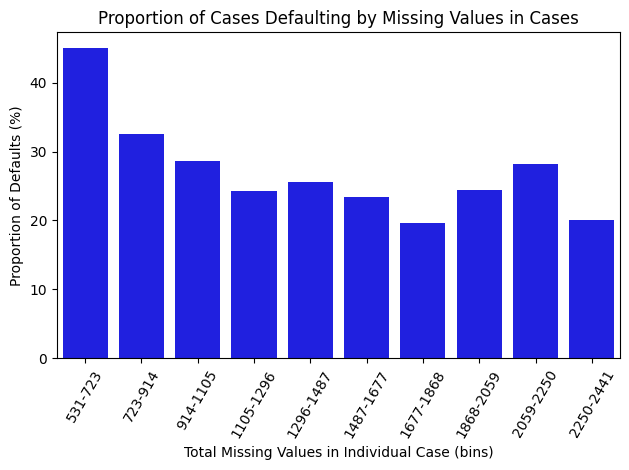

In [185]:
sns.barplot(data=default_counts, x='null_bin', y='pct', color='blue')

# Remove decimals in xticks
bins_list = default_counts['null_bin'].unique().tolist()
x_tick_labels = [ f'{int(cat.left)}-{int(cat.right)}' for cat in bins_list ]

plt.xticks(ticks=range(n_bins), labels=x_tick_labels, rotation=60)
plt.xlabel('Total Missing Values in Individual Case (bins)')
plt.ylabel('Proportion of Defaults (%)')
plt.title('Proportion of Cases Defaulting by Missing Values in Cases')
plt.tight_layout()
plt.show()

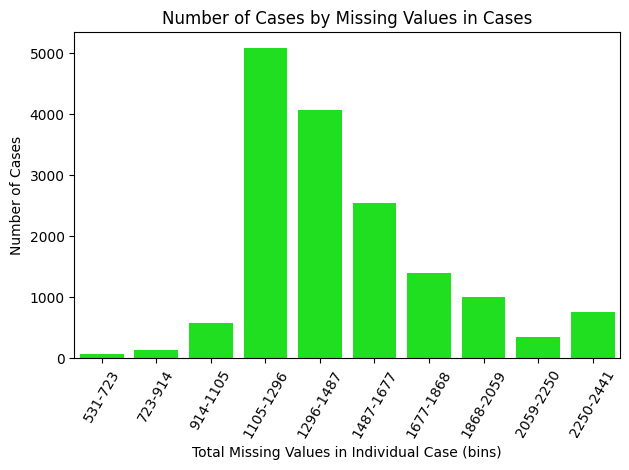

In [186]:
sns.barplot(data=total_counts, x='null_bin', y='target', color='lime')

# Remove decimals in xticks
bins_list = total_counts['null_bin'].unique().tolist()
x_tick_labels = [ f'{int(cat.left)}-{int(cat.right)}' for cat in bins_list ]

plt.xticks(ticks=range(n_bins), labels=x_tick_labels, rotation=60)
plt.xlabel('Total Missing Values in Individual Case (bins)')
plt.ylabel('Number of Cases')
plt.title('Number of Cases by Missing Values in Cases')
plt.tight_layout()
plt.show()

Observations: The low total missing value count cases appear to not only be outliers but also highly predictive of likelihood of default.

#### Removing Columns where Missing data is more than 95% 

We remove columns with over 95% missing data as due to our train-validation-test split, missing value imputation will nearly be impossible on extremely sparse columns as long runs of missing values on cases may lead to the training data to having columns which contain all null values.

In [187]:
# Train and validation data
val_prop = 0.3
val_size = int(len(train_set) * val_prop)
train_size = len(train_set) - val_size
train_df = train_set.iloc[:train_size].copy()
valid_df = train_set.iloc[-val_size:].copy()

# Remove columns with more than 95% missing values
missing_threshold = 0.95
train_df = train_df[train_df.columns[train_df.isnull().mean() < missing_threshold]]

# Remove columns from validation and test
valid_df = valid_df[train_df.columns]
test_df = test_set[train_df.columns].copy()

In [188]:
# Create X and y
X_train = train_df.drop(columns=['case_id', 'target'])
X_valid = valid_df.drop(columns=['case_id', 'target'])
X_test = test_df.drop(columns=['case_id', 'target'])
y_train = train_df['target']
y_valid = valid_df['target']
y_test = test_df['target']

### Basic and Baseline Model Analysis

Create a Random Model: This model will predict the target label based solely on the average percentage distribution of classes in the entire dataset.

Build Baseline Models: Using the initially pre-processed data and missing values mean imputation, we will construct three baseline models:

Logistic Regression
Decision Tree
LightGBM
Objective

The goal of this exercise is to establish baseline performance metrics, allowing us to compare these initial models with future models that incorporate more advanced transformations and methods. This comparison will help us determine if further enhancements lead to statistically significant improvements in accuracy and model stability.

In [189]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE

### Basic Model Predictor based on target percentage - Weighted Random Chance

In [190]:
# The percentage of target = 1 in entire dataset
percentage_target_1 = 3
print(f"Percentage of target = 1: {percentage_target_1:.2f}%")


def model_percentage(data, percentage):
    random_numbers = np.random.rand(len(data))
    predictions = (random_numbers < (percentage / 100)).astype(int)
    return predictions

Percentage of target = 1: 3.00%


### Score Metrics Basic Model

We hardcode the target positive class average to 3% which comes from the complete dataset. 

In [191]:
# Apply the model to base_valid
y_valid_pred = model_percentage(X_valid, percentage_target_1)

# Evaluate the model
auc_score = roc_auc_score(y_valid, y_valid_pred)
precision = precision_score(y_valid, y_valid_pred)
recall = recall_score(y_valid, y_valid_pred)
accuracy = accuracy_score(y_valid, y_valid_pred)
f1 = f1_score(y_valid, y_valid_pred)

# Print the evaluation metrics
print(f"AUC: {auc_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

AUC: 0.5012
Precision: 0.2581
Recall: 0.0341
Accuracy: 0.7400
F1 Score: 0.0602


The AUC score reflects the model's ability to distinguish between classes. A score closer to 0.5 indicates that the model performs no better than random guessing. Given that this is a random model based on the target's percentage, an AUC score near 0.5 is expected and confirms the model's lack of discriminatory power.

Precision measures the proportion of true positives among all positive predictions. For a random model, precision is typically low as it doesn't have any mechanism to prioritize true positives over false positives.

Recall measures the proportion of actual positives that are correctly identified by the model. A random model's recall is generally proportional to the actual prevalence of the positive class in the dataset. 

Accuracy measures the proportion of all correct predictions (both true positives and true negatives) out of the total predictions. For a random model, the accuracy is influenced by the class distribution in the dataset. An accuracy score that is close to the proportion of the majority class indicates that the model might be leaning towards predicting the majority class more often.

The F1 score is the harmonic mean of precision and recall, providing a balance between the two. We see for this model that is low, reflecting the trade-off between precision and recall when there is no specific pattern in the predictions.

### Baseline Model

A more sofisticated Baseline we could use would be to train a Logistic Regressor, Decision Tree Classifier or LGBM Classier on their respective default parameters, which are pre-tuned to work reasonably well for a wide range of datasets. Moreover, we will use a simple mean imputer to handle the missing data. With in our use case is 92%. 

In [192]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_valid_imputed = imputer.transform(X_valid)

In [193]:
# Define the models
models = {
    "Logistic Regression": LogisticRegression(random_state=1),
    "Decision Tree": DecisionTreeClassifier(random_state=1),
    "LightGBM": LGBMClassifier(random_state=1, verbose=-1)
}

# Function to evaluate and print metrics
def evaluate_model(name, y_true, y_pred, y_pred_probs):
    auc_score = roc_auc_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"--- {name} ---")
    print(f"AUC: {auc_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

# Iterate through models
for name, model in models.items():
    # Fit the model
    model.fit(X_train_imputed, y_train)
    
    # Predict probabilities and classes
    y_valid_pred_probs = model.predict_proba(X_valid_imputed)[:, 1]
    y_valid_pred = model.predict(X_valid_imputed)
    
    # Evaluate the model
    evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)


--- Logistic Regression ---
AUC: 0.5428
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.7552
F1 Score: 0.0000

--- Decision Tree ---
AUC: 0.5657
Precision: 0.3116
Recall: 0.4604
Accuracy: 0.6196
F1 Score: 0.3716

--- LightGBM ---
AUC: 0.7921
Precision: 0.5596
Recall: 0.4723
Accuracy: 0.7802
F1 Score: 0.5123



Baselines Model Performance Overview
- Logistic Regression
  - Auc: Slightly better than random guessing (AUC of 0.5). Indicates poor discriminatory power.
  - Precision: Model did not predict any positives, reflects difficulty in handling class imbalance.
  - Recall: Model failed to capture any true positives.Indicates that the model is biased towards predicting the majority class (negative).
  - Accuracy: High accuracy, but misleading due to class imbalance.
  - F1 Score: Awful.

**Logistic Regression struggles with the imbalanced dataset, failing to predict the minority class, resulting in poor performance across all metrics except accuracy (missleading due to class imbalance).**

- Decision Tree
  - AUC: Slightly better than Logistic Regression. Shows moderately more discriminatory power.
  - Precision: Indicates some ability to correctly predict positive cases.Affected by class imbalance.
  - Recall: Much better at capturing true positives than Logistic Regression. Reflects some sensitivity to the minority class.
  - Accuracy: Lower than Logistic Regression, but this is due to better handling of positive (default) cases.
  - F1 Score: Better balance between precision and recall.


**The Decision Tree shows improved handling of the minority class compared to Logistic Regression, with better precision, recall, and F1 score, though it still struggles with the class imbalance.**

- LightGBM
  - AUC: Significantly better than Logistic Regression and Decision Tree.
  - Precision: Highest precision among the models. Better at correctly predicting positive cases.
  - Recall: Slightly better recall, still indicating some challenges in capturing all true positives.
  - Accuracy: High accuracy, though influenced by class imbalance.
  - F1 Score: Reflects better performance in handling the imbalanced dataset.


**LightGBM outperforms the other models, especially in terms of AUC and precision, demonstrating better handling of the imbalanced dataset. The model’s ability to auto-tune parameters and handle missing data contributes to its superior performance.**

### Comparison of LightGBM Performance: Mean Imputation vs. Handling Missing Values Directly

Finally, let's check how LightGBM performs with the preprocessed data with the missing values, instead of the mean impute.

The lightGBM model accounts with a handling of missing values build in. It treats missing values as a separate category so:

- Split Finding with Missing Values: Missing Value as a Separate Category: LightGBM treats missing values as a separate category when finding splits. During training, it can decide whether to assign missing values to the left or right side of a split.
- Optimal Split Decision: LightGBM evaluates the best way to handle missing values by considering them during the split-finding process. This means it optimally decides where to place missing values to minimize the loss function.

Reference: LightGBM's official documentation: LightGBM Handling Missing Values. https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#missing-value-handle

In [194]:
model = LGBMClassifier(random_state=1, verbose=-1)
# Fit the model
model.fit(X_train, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model.predict_proba(X_valid)[:, 1]
y_valid_pred = model.predict(X_valid)

# Evaluate the model
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

--- LightGBM ---
AUC: 0.7940
Precision: 0.5459
Recall: 0.4663
Accuracy: 0.7748
F1 Score: 0.5030



A roughly the same as with mean imputation.

### Missing Value Imputation Strategies

1. KNN Imputation:

We will employ KNN imputation, which predicts missing values using the mean or median of the k-nearest neighbors found in the training set. Two configurations will be tested:
    - 5 Neighbors: A tighter cluster which may capture more localized data patterns.
    - 10 Neighbors: A broader cluster to generalize better over the input space.

2. Binary Flag for Missing Values:

Alongside numerical imputation, we will add a binary indicator (flag) for each feature to signal the presence of an imputation. This method helps the model identify patterns associated with the occurrence of missing data.

3. Mean and Median Imputer:

These are straightforward approaches where missing values are replaced with the mean or median of the respective feature. The mean is sensitive to outliers, whereas the median provides a more robust estimate in such cases.

#### Visualization and Evaluation:
1. t-SNE Visualization:

Post-imputation, we will utilize t-SNE (t-Distributed Stochastic Neighbor Embedding) to visualize the dataset. This technique will help us observe any distinct patterns or clusters that emerge after imputation, providing insights into how different strategies group the data.

1. KNN Imputation: 5 neighbors and 10 neighbors with binary missing flag.

In [195]:
# Identify columns
numerical_columns = X_train.select_dtypes(include=[np.number]).columns

X_train_knn_imputed_5 = X_train.copy()
X_valid_knn_imputed_5 = X_valid.copy()
X_test_knn_imputed_5 = X_test.copy()

# Create binary indicator for missing values
for col in numerical_columns:
    X_train_knn_imputed_5[col + '_missing'] = X_train_knn_imputed_5[col].isna().astype(int)
    X_valid_knn_imputed_5[col + '_missing'] = X_valid_knn_imputed_5[col].isna().astype(int)
    X_test_knn_imputed_5[col + '_missing'] = X_test_knn_imputed_5[col].isnull().astype(int)

# Fit KNN imputer 
knn_imputer = KNNImputer(n_neighbors=5)
X_train_knn_imputed_5 = knn_imputer.fit_transform(X_train_knn_imputed_5[numerical_columns])
X_valid_knn_imputed_5 = knn_imputer.transform(X_valid_knn_imputed_5[numerical_columns])
X_test_knn_imputed_5 = knn_imputer.transform(X_test_knn_imputed_5[numerical_columns])
X_train_knn_imputed_5 = pd.DataFrame(X_train_knn_imputed_5)
X_valid_knn_imputed_5 = pd.DataFrame(X_valid_knn_imputed_5)
X_test_knn_imputed_5 = pd.DataFrame(X_test_knn_imputed_5)

In [196]:
# Identify columns
numerical_columns = X_train.select_dtypes(include=[np.number]).columns

X_train_knn_imputed_10 = X_train.copy()
X_valid_knn_imputed_10 = X_valid.copy()
X_test_knn_imputed_10 = X_test.copy()

# Create binary indicator for missing values
for col in numerical_columns:
    X_train_knn_imputed_10[col + '_missing'] = X_train_knn_imputed_10[col].isna().astype(int)
    X_valid_knn_imputed_10[col + '_missing'] = X_valid_knn_imputed_10[col].isna().astype(int)
    X_test_knn_imputed_10[col + '_missing'] = X_test_knn_imputed_10[col].isnull().astype(int)

# Fit KNN imputer 
knn_imputer = KNNImputer(n_neighbors=10)
X_train_knn_imputed_10 = knn_imputer.fit_transform(X_train_knn_imputed_10[numerical_columns])
X_valid_knn_imputed_10 = knn_imputer.transform(X_valid_knn_imputed_10[numerical_columns])
X_test_knn_imputed_10 = knn_imputer.transform(X_test_knn_imputed_10[numerical_columns])
X_train_knn_imputed_10 = pd.DataFrame(X_train_knn_imputed_10)
X_valid_knn_imputed_10 = pd.DataFrame(X_valid_knn_imputed_10)
X_test_knn_imputed_10 = pd.DataFrame(X_test_knn_imputed_10)

2. Imputation: Median and Binary flag Indicator for missing values.

In [197]:
# Identify columns
numerical_columns = X_train.select_dtypes(include=[np.number]).columns

X_train_imputed = X_train.copy()
X_valid_imputed = X_valid.copy()
X_test_imputed = X_test.copy()

# Create binary indicator for missing values
for col in numerical_columns:
    X_train_imputed[col + '_missing'] = X_train_imputed[col].isna().astype(int)
    X_valid_imputed[col + '_missing'] = X_valid_imputed[col].isna().astype(int)
    X_test_imputed[col + '_missing'] = X_test_imputed[col].isnull().astype(int)

# Impute missing values with median
median_imputer = SimpleImputer(strategy='median')
X_train_imputed[numerical_columns] = median_imputer.fit_transform(X_train_imputed[numerical_columns])
X_valid_imputed[numerical_columns] = median_imputer.transform(X_valid_imputed[numerical_columns])
X_test_imputed[numerical_columns] = median_imputer.transform(X_test_imputed[numerical_columns])

3. Imputation: Mean and Binary flag Indicator for missing values.

In [198]:
# Identify columns
numerical_columns = X_train.select_dtypes(include=[np.number]).columns

X_train_imputed_average = X_train.copy()
X_valid_imputed_average = X_valid.copy()
X_test_imputed_average = X_test.copy()


# Create binary indicator for missing values
for col in numerical_columns:
    X_train_imputed_average[col + '_missing'] = X_train_imputed_average[col].isnull().astype(int)
    X_valid_imputed_average[col + '_missing'] = X_valid_imputed_average[col].isnull().astype(int)
    X_test_imputed_average[col + '_missing'] = X_test_imputed_average[col].isnull().astype(int)

# Impute missing values with median
mean_imputer = SimpleImputer(strategy='mean')
X_train_imputed_average[numerical_columns] = mean_imputer.fit_transform(X_train_imputed_average[numerical_columns])
X_valid_imputed_average[numerical_columns] = mean_imputer.transform(X_valid_imputed_average[numerical_columns])
X_test_imputed_average[numerical_columns] = mean_imputer.transform(X_test_imputed_average[numerical_columns])

#### Proving More Distinct Patterns Post-Imputation visually with t-SNE

To effectively demonstrate the distinct patterns emerging from different imputation strategies, we will utilize t-SNE (t-Distributed Stochastic Neighbor Embedding). This technique is particularly valuable for visualizing high-dimensional data in a lower-dimensional space, typically two dimensions, which makes it easier to identify clusters and separations among data points.

For the first graph, as t-SNE does not inherently accommodate missing values. To prepare our dataset for t-SNE visualization:
For categorical features: Convert NaNs to a unique category, ensuring they are treated distinctly during the dimensionality reduction.
For numerical features: Substitute NaNs with a specific numerical value (e.g., -999). This method marks missing entries distinctly, allowing us to observe how t-SNE handles these values compared to the rest of the dataset.


In [199]:
# Function to preprocess data, handle NaNs, and apply t-SNE
def preprocess_and_tsne_with_nan_handling(X, y, title):
    # Copy the dataset to avoid changing the original
    X_encoded = X.copy()
    
    # Handle NaNs in categorical columns
    for column in X_encoded.select_dtypes(include=['object', 'category']).columns:
        X_encoded[column] = X_encoded[column].fillna('NULL')  # Replace NaNs with 'NULL'
        le = LabelEncoder()
        X_encoded[column] = le.fit_transform(X_encoded[column].astype(str))
    
    # Handle NaNs in numerical columns
    for column in X_encoded.select_dtypes(exclude=['object', 'category']).columns:
        X_encoded[column] = X_encoded[column].fillna(-999)  # Replace NaNs with -999
    
    # Initialize and apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(X_encoded)
    
    # Create a DataFrame with t-SNE results and target
    tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['target'] = y.reset_index(drop=True)
    
    # Plot the t-SNE results
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        x='TSNE1', y='TSNE2',
        hue='target',
        palette={0: 'lime', 1: 'blue'},
        data=tsne_df,
        alpha=0.6

    )
    plt.title(title)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Target')
    plt.grid(True)
    plt.show()

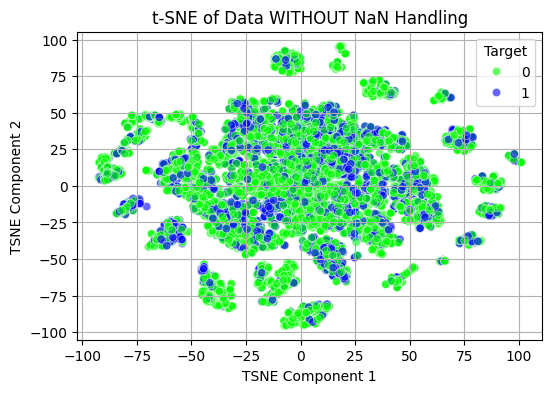

In [200]:
preprocess_and_tsne_with_nan_handling(X_train, y_train, 't-SNE of Data WITHOUT NaN Handling')

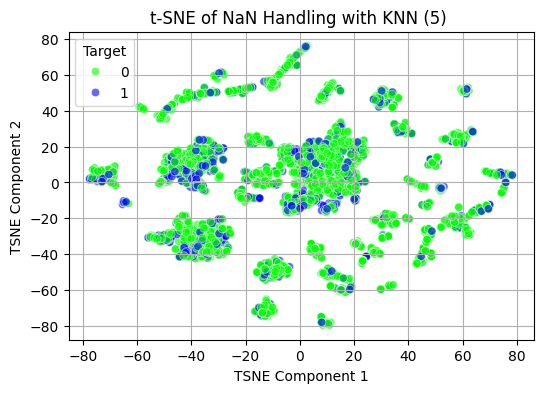

In [201]:
preprocess_and_tsne_with_nan_handling(X_valid_knn_imputed_5, y_valid, 't-SNE of NaN Handling with KNN (5) ')

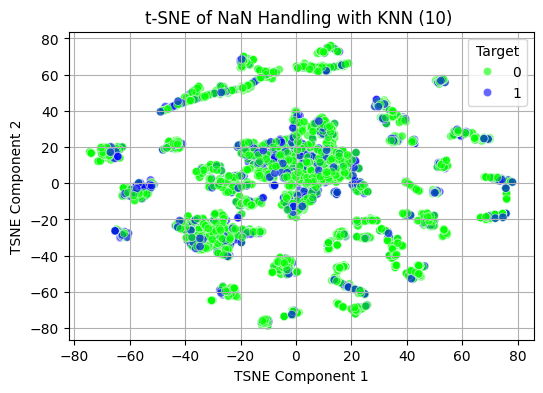

In [202]:
preprocess_and_tsne_with_nan_handling(X_valid_knn_imputed_10, y_valid, 't-SNE of NaN Handling with KNN (10) ')

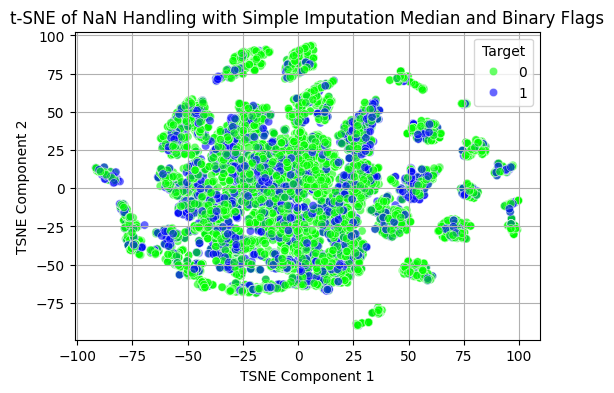

In [203]:
preprocess_and_tsne_with_nan_handling(X_train_imputed, y_train, 't-SNE of NaN Handling with Simple Imputation Median and Binary Flags')

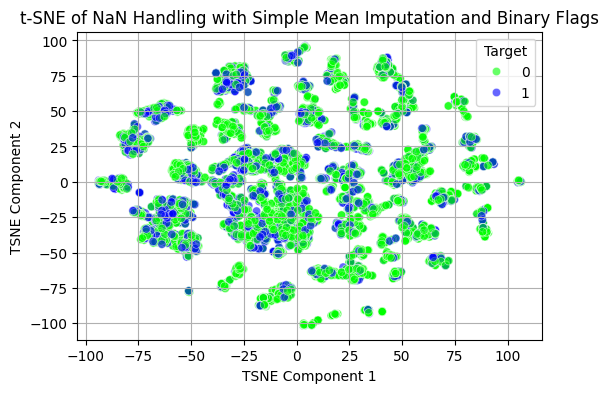

In [204]:
preprocess_and_tsne_with_nan_handling(X_train_imputed_average, y_train, 't-SNE of NaN Handling with Simple Mean Imputation and Binary Flags')

Observation: The visualization reveals more distinct patterns when we implement the Mean Target NaN Imputation method (positive cases appear to be more on the lefthand side of the plot). We will proceed to quantitatively evaluate and compare the performance metrics of this approach in the following section to verify if the observed visual distinctions translate into improved predictive accuracy.

### Post-Imputation Model Evaluation:

Following each imputation method, we will retrain our model and evaluate its performance. Key metrics will include accuracy, F1 score, and AUC-ROC, among others. This step is crucial to determine whether the imputation technique enhances the model’s predictive power or detracts from it.

By systematically implementing and comparing these imputation methods, we aim to identify the strategy that most effectively enhances our model's ability to predict true positives, while addressing the challenges posed by missing values in our dataset.

Imputed KNN 5 neighbors

In [205]:
model_mean_knn5 = LGBMClassifier(random_state=1, verbose=-1)
# Fit the model
model_mean_knn5.fit(X_train_knn_imputed_5, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_mean_knn5.predict_proba(X_valid_knn_imputed_5)[:, 1]
y_valid_pred = model_mean_knn5.predict(X_valid_knn_imputed_5)

# Evaluate the model
name='lightGBM with NaN KNN 5 neighbours Inputed'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)


--- lightGBM with NaN KNN 5 neighbours Inputed ---
AUC: 0.7867
Precision: 0.5329
Recall: 0.4766
Accuracy: 0.7700
F1 Score: 0.5032



Imputed KNN 10 neighbors

In [206]:
model_mean_knn10 = LGBMClassifier(random_state=1, verbose=-1)
# Fit the model
model_mean_knn10.fit(X_train_knn_imputed_10, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_mean_knn10.predict_proba(X_valid_knn_imputed_10)[:, 1]
y_valid_pred = model_mean_knn10.predict(X_valid_knn_imputed_10)

# Evaluate the model
name='lightGBM with NaN KNN 10 neighbours Inputed'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)


--- lightGBM with NaN KNN 10 neighbours Inputed ---
AUC: 0.7872
Precision: 0.5462
Recall: 0.4638
Accuracy: 0.7748
F1 Score: 0.5016



Imputed Median Simple Imputer and Numerical Missing Binary Flag

In [207]:
model_median = LGBMClassifier(random_state=1, verbose=-1)
# Fit the model
model_median.fit(X_train_imputed, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_median.predict_proba(X_valid_imputed)[:, 1]
y_valid_pred = model_median.predict(X_valid_imputed)

# Evaluate the model
name = 'lightGBM with NaN Imputer Median Simple Imputer and Binary Flag'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

--- lightGBM with NaN Imputer Median Simple Imputer and Binary Flag ---
AUC: 0.7956
Precision: 0.5608
Recall: 0.4834
Accuracy: 0.7812
F1 Score: 0.5192



Imputed Mean Simple Imputer and Numerical Missing Binary Flag

In [208]:
model_mean = LGBMClassifier(random_state=1, verbose=-1)
# Fit the model
model_mean.fit(X_train_imputed_average, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_mean.predict_proba(X_valid_imputed_average)[:, 1]
y_valid_pred = model_mean.predict(X_valid_imputed_average)

# Evaluate the model
name='lightGBM with NaN Imputer Mean Simple Imputer and Binary Flag'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

--- lightGBM with NaN Imputer Mean Simple Imputer and Binary Flag ---
AUC: 0.7921
Precision: 0.5571
Recall: 0.4655
Accuracy: 0.7790
F1 Score: 0.5072



Observation: We will be selecting the Median Imputed values since it has improved the model's ability to both reduce false negatives.

### Standardization of the Data

We need to standardize the data before applying the variation threshold and other more complex transformations.

We will compare between Standard Scaler and Robust Scaler (robust to outliers using statistics like median and interquantile range).

In [209]:
# Initialize RobustScaler
robust_scaler = RobustScaler()
std_scaler = StandardScaler()

In [210]:
# Fit and transform on training data, transform on validation data
X_train_scaled_robust = robust_scaler.fit_transform(X_train_imputed)
X_valid_scaled_robust = robust_scaler.transform(X_valid_imputed)
X_test_scaled_robust = robust_scaler.transform(X_test_imputed)

X_train_scaled_std = std_scaler.fit_transform(X_train_imputed)
X_valid_scaled_std = std_scaler.transform(X_valid_imputed)
X_test_scaled_std = std_scaler.transform(X_test_imputed)


# Convert back to DataFrame
X_train_scaled_robust = pd.DataFrame(X_train_scaled_robust, columns=X_train_imputed.columns)
X_valid_scaled_robust = pd.DataFrame(X_valid_scaled_robust, columns=X_valid_imputed.columns)
X_test_scaled_robust = pd.DataFrame(X_test_scaled_robust, columns=X_test_imputed.columns)

X_train_scaled_std = pd.DataFrame(X_train_scaled_std, columns=X_train_imputed.columns)
X_valid_scaled_std = pd.DataFrame(X_valid_scaled_std, columns=X_valid_imputed.columns)
X_test_scaled_std = pd.DataFrame(X_test_scaled_std, columns=X_test_imputed.columns)

Let's check the model performance, we do not expect a drastic change because the tree based model are not highly affected by the scale of the features. We are doing scaling to be able to apply other distance based dimension reduction methods.

In [211]:
model_scaled_robust = LGBMClassifier(random_state=1, verbose=-1)
# Fit the model
model_scaled_robust.fit(X_train_scaled_robust, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_scaled_robust.predict_proba(X_valid_scaled_robust)[:, 1]
y_valid_pred = model_scaled_robust.predict(X_valid_scaled_robust)

# Evaluate the model
name='lightGBM with Scaled Features with RobustScaler'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

--- lightGBM with Scaled Features with RobustScaler ---
AUC: 0.7949
Precision: 0.5573
Recall: 0.4808
Accuracy: 0.7798
F1 Score: 0.5162



In [212]:
model_scaled = LGBMClassifier(random_state=1, verbose=-1)
# Fit the model
model_scaled.fit(X_train_scaled_std, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_scaled.predict_proba(X_valid_scaled_std)[:, 1]
y_valid_pred = model_scaled.predict(X_valid_scaled_std)

# Evaluate the model
name='lightGBM with Scaled Features with StandardScaler'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

--- lightGBM with Scaled Features with StandardScaler ---
AUC: 0.7990
Precision: 0.5678
Recall: 0.4893
Accuracy: 0.7842
F1 Score: 0.5256



Observation: After applying scaling to the data, we notice a degradation in the model's performance. This decline may be attributed to the scaling process diminishing the impact of outliers, which, as previously identified, hold critical information for predicting the positive class.

Next Steps: We will next explore the impact of dimensionality reduction techniques. This will help us determine if reducing the number of dimensions can enhance the model's predictive power, potentially offsetting the negative effects observed post-scaling.

### Threshold Variance

We apply threshold variance so the dimensionality algorithms are faster to compute. 

In [213]:
# Apply VarianceThreshold to remove low-variance features
varianceThreshold = VarianceThreshold(threshold=0.1)
X_train_reduced = varianceThreshold.fit_transform(X_train_scaled_std)
X_valid_reduced = varianceThreshold.transform(X_valid_scaled_std)
X_test_reduced = varianceThreshold.transform(X_test_scaled_std)

In [214]:
print('Shape training dataset before threshold variance', X_train_scaled_std.shape)
print('Shape training dataset after threshold variance', X_train_reduced.shape)

Shape training dataset before threshold variance (11200, 3612)
Shape training dataset after threshold variance (11200, 3288)


We reduced the dataset on roughly 300 columns.

### Dimensionality Reduction Algorithms

1. Principal Component Analysis (PCA)

Description: PCA is a linear dimensionality reduction technique that transforms the data into a set of orthogonal components that capture the maximum variance.
Advantages:
Handles large datasets efficiently.
Reduces dimensionality while retaining as much variance as possible.
Limitations:
Assumes linear relationships.
May not perform well if the data is not linearly separable.
Suitability: Good for initial dimensionality reduction, especially when combined with other methods.

2. Linear Discriminant Analysis (LDA)

Description: LDA is a supervised technique that maximizes the separation between multiple classes.
Advantages:
Focuses on maximizing class separability.
Useful for classification tasks.
Limitations:
Assumes normally distributed classes with equal covariance matrices.
Limited to supervised settings.
Suitability: Best when the goal is to enhance class separability, especially in classification problems.

3. t-Distributed Stochastic Neighbor Embedding (t-SNE)

Description: t-SNE is a non-linear technique that visualizes high-dimensional data in lower dimensions by preserving local similarities.
Advantages:
Excellent for visualizing clusters.
Captures non-linear relationships.
Limitations:
Computationally intensive.
Primarily used for visualization rather than feature reduction for modeling.
Suitability: Best for visualizing complex patterns and clusters.

We apply PCA and again we visualize with t-SNE

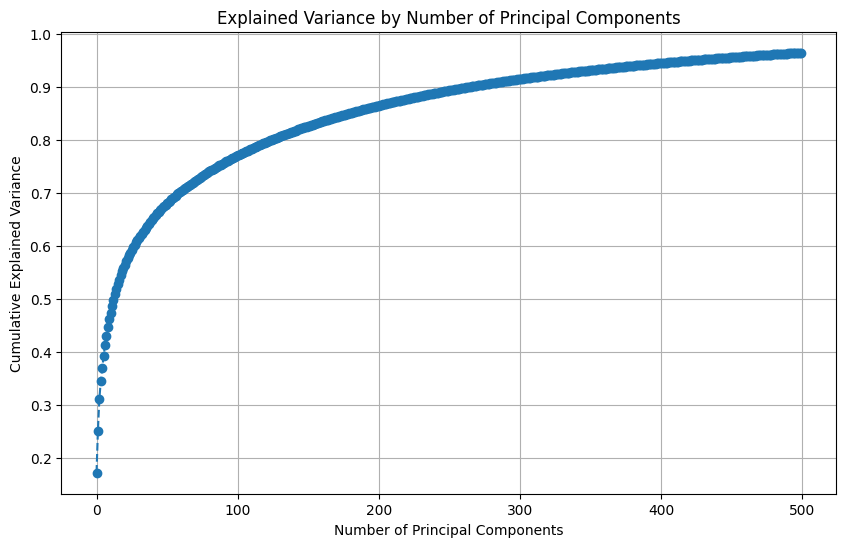

In [215]:
# Apply PCA on scaled and reduced training data
pca = PCA(n_components=500)  
X_train_reduced_pca = pca.fit_transform(X_train_reduced)
X_valid_reduced_pca = pca.transform(X_valid_reduced)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()

We would like to keep 95% of explained variance, so we would transform the space into 500 principal components.

In [216]:
# Function to preprocess data, handle NaNs, and apply t-SNE
def tsne_plot(X, y, title):
    # Copy the dataset to avoid changing the original
    X_encoded = X.copy()
        
    # Initialize and apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(X_encoded)
    
    # Create a DataFrame with t-SNE results and target
    tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['target'] = y.reset_index(drop=True)
    
    # Plot the t-SNE results
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        x='TSNE1', y='TSNE2',
        hue='target',
        palette=sns.color_palette('hsv', len(tsne_df['target'].unique())),
        data=tsne_df,
        alpha=0.3

    )
    plt.title(title)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Target')
    plt.grid(True)
    plt.show()

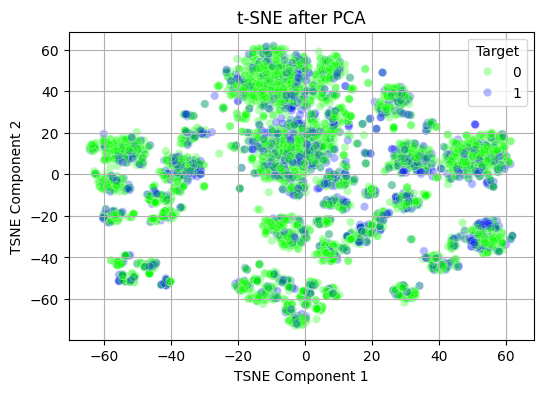

In [217]:
tsne_plot(X_valid_reduced_pca, y_valid, 't-SNE after PCA')

We see that after PCA it is visually not easier to distinguish between both classes.

Using other dimensionality Reduction Algorithm LDA: Linear Discriminant Analysis.

$Number of Components = min(Number of Classes−1, Number of Features)$

In [218]:
# Apply LDA on training data
lda = LDA(n_components=1)  # n_components based on the number of classes
X_train_reduced_lda = lda.fit_transform(X_train_reduced, y_train)
X_valid_reduced_lda = lda.transform(X_valid_reduced)
X_test_reduced_lda = lda.transform(X_test_reduced)

The visualization below is from a reduced dataset `le_final_model_final_report.ipynb`.

In [220]:
# tsne_plot(X_valid_reduced_lda, y_valid, 't-SNE after LDA')

![tsne LDA](./figures/tsne_LDA.png)

### Post-Dimensionality Reduction Evaluation:

Purpose: Evaluate how dimensionality reduction affects model performance looking at the classification metrics.

In [221]:
model_reduced_pca = LGBMClassifier(random_state=1, verbose=-1)
# Fit the model
model_reduced_pca.fit(X_train_reduced_pca, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_reduced_pca.predict_proba(X_valid_reduced_pca)[:, 1]
y_valid_pred = model_reduced_pca.predict(X_valid_reduced_pca)

# Evaluate the model
name = 'lightGBM with Scaled Features with StandardScaler Scaler and LDA'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)


--- lightGBM with Scaled Features with StandardScaler Scaler and LDA ---
AUC: 0.6973
Precision: 0.4577
Recall: 0.2217
Accuracy: 0.7456
F1 Score: 0.2987



In [222]:
model_reduced = LGBMClassifier(random_state=1, verbose=-1)
# Fit the model
model_reduced.fit(X_train_reduced_lda, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_reduced.predict_proba(X_valid_reduced_lda)[:, 1]
y_valid_pred = model_reduced.predict(X_valid_reduced_lda)

# Evaluate the model
name = 'lightGBM with Scaled Features with StandardScaler Scaler and LDA'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)


--- lightGBM with Scaled Features with StandardScaler Scaler and LDA ---
AUC: 0.7215
Precision: 0.4593
Recall: 0.5098
Accuracy: 0.7335
F1 Score: 0.4832



Observation: It looks as though standardization and dimensionality reduction has hurt the model's ability to predict.

Next Steps: In the final stages of model building, we will conduct a comparative analysis of the model's performance with and without applying LDA (Linear Discriminant Analysis) for dimensionality reduction. Although we anticipate some improvement in performance metrics through the sequential application of our preprocessing steps, we are cautious about the potential downsides of reducing the dataset to a single dimension. Such a significant reduction could impair the model's ability to learn complex patterns and relationships among features, as the data would be represented by a single composite feature. This could, in turn, diminish the predictive power of the model. We aim to validate this hypothesis in the forthcoming steps.

### Handling Class inbalance applying SMOTE on training data

In [223]:
# Apply SMOTE on training data after LDA 
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reduced_lda, y_train)


# Apply SMOTE on training data without LDA, high dimensions (hd)
smote_hd = SMOTE(random_state=42)
X_train_resampled_hd, y_train_resampled_hd = smote_hd.fit_resample(X_train_reduced, y_train)

#### SMOTE evaluation Evaluation:


We check the performance of SMOTE after the LDA dimensionality reduction step.

In [226]:
model_balanced = LGBMClassifier(random_state=1, verbose=-1)
# Fit the model
model_balanced.fit(X_train_resampled, y_train_resampled)

# Predict probabilities and classes
y_valid_pred_probs = model_balanced.predict_proba(X_valid_reduced_lda)[:, 1]
y_valid_pred = model_balanced.predict(X_valid_reduced_lda)

# Evaluate the model
name = 'lightGBM with Scaled Features with StandardScaler Scaler and LDA and SMOTE'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

--- lightGBM with Scaled Features with StandardScaler Scaler and LDA and SMOTE ---
AUC: 0.7204
Precision: 0.3876
Recall: 0.6965
Accuracy: 0.6569
F1 Score: 0.4980



We check the performance after the SMOTE without the LDA step. 

In [227]:
model_balanced = LGBMClassifier(random_state=1, verbose=-1)
# Fit the model
model_balanced.fit(X_train_resampled_hd, y_train_resampled_hd)

# Predict probabilities and classes
y_valid_pred_probs = model_balanced.predict_proba(X_valid_reduced)[:, 1]
y_valid_pred = model_balanced.predict(X_valid_reduced)

# Evaluate the model
name = 'lightGBM with Scaled Features with StandardScaler Scaler and SMOTE'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

--- lightGBM with Scaled Features with StandardScaler Scaler and SMOTE ---
AUC: 0.7945
Precision: 0.5653
Recall: 0.4723
Accuracy: 0.7823
F1 Score: 0.5146



Observation: The application of SMOTE has shown improved performance following all our preprocessing transformations, increasing recall with a trade off on precision.

Decision: Based on these findings, we will proceed with these transformations, for our final model configuration. This approach should optimize our model’s ability to accurately predict outcomes by preserving the essential characteristics of the data.

We will try to optimize both, the traning data with and without LDA reduction to F1. We get better reuslts after applyin LDA but we want to make sure that that is still the case after applying hyperparameter tunning

### Final Model Evaluation after adding hyperparameter tunning and Regularization

Optimizing the model without the LDA transformation on F1.

In [228]:
# LightGBM hyperparameters grid for tuning
param_grid = {
  'num_leaves': [20, 31, 40, 50, 60],
  'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
  'n_estimators': [100, 200, 300, 400, 500],
  'max_depth': [-1, 10, 15, 20, 25],
  'min_child_weight': [1, 3, 5, 7],
  'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
  'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
  'reg_alpha': [0.0, 0.1, 0.5, 1.0],
  'reg_lambda': [0.0, 0.1, 0.5, 1.0],
  'objective': ['binary', 'tweedie']
}

# Initialize the LGBMClassifier
model = LGBMClassifier(random_state=1, verbose=-1)

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    scoring='f1',
    n_iter=50,  # Number of parameter settings sampled
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
    verbose=0,
    random_state=1
)

# Fit the model
random_search.fit(X_train_resampled_hd, y_train_resampled_hd)

# Get the best model
best_model_hd = random_search.best_estimator_

# Predict probabilities and classes
y_valid_pred_probs = best_model_hd.predict_proba(X_valid_reduced)[:, 1]
y_valid_pred = best_model_hd.predict(X_valid_reduced)

# Evaluate the tuned model
name = 'LightGBM with Scaled Features with StandardScaler, SMOTE, Regularization and Randomized Hyperparameter Tuning'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

--- LightGBM with Scaled Features with StandardScaler, SMOTE, Regularization and Randomized Hyperparameter Tuning ---
AUC: 0.7562
Precision: 0.5894
Recall: 0.0759
Accuracy: 0.7612
F1 Score: 0.1344



Optimizing the model with the LDA transformation on F1 score.

In [229]:
# LightGBM hyperparameters grid for tuning
param_grid = {
  'num_leaves': [20, 31, 40, 50, 60],
  'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
  'n_estimators': [100, 200, 300, 400, 500],
  'max_depth': [-1, 10, 15, 20, 25],
  'min_child_weight': [1, 3, 5, 7],
  'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
  'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
  'reg_alpha': [0.0, 0.1, 0.5, 1.0],
  'reg_lambda': [0.0, 0.1, 0.5, 1.0],
  'objective': ['binary', 'tweedie']
}

# Initialize the LGBMClassifier
model = LGBMClassifier(random_state=1, verbose=-1)

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    scoring='f1',
    n_iter=50,  # Number of parameter settings sampled
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
    verbose=0,
    random_state=1
)

# Fit the model
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model_rd = random_search.best_estimator_

# Predict probabilities and classes
y_valid_pred_probs = best_model_rd.predict_proba(X_valid_reduced_lda)[:, 1]
y_valid_pred = best_model_rd.predict(X_valid_reduced_lda)

# Evaluate the tuned model
name = 'LightGBM with Scaled Features with StandardScaler, LDA, SMOTE, Regularization and Randomized Hyperparameter Tuning'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)


--- LightGBM with Scaled Features with StandardScaler, LDA, SMOTE, Regularization and Randomized Hyperparameter Tuning ---
AUC: 0.7218
Precision: 0.3877
Recall: 0.6948
Accuracy: 0.6573
F1 Score: 0.4977



We conducted a comparative analysis of two LightGBM models optimized using Randomized Hyperparameter Tuning, each processed with 5-fold cross-validation on 50 candidates, totaling 250 fits for each model. The primary difference between the models is the inclusion of Linear Discriminant Analysis (LDA) in one of the models.

- Model with LDA (Dimensionality Reduction):
Configuration: Scaled features with StandardScaler, LDA for dimensionality reduction, SMOTE for handling class imbalance, and regularization. This model demonstrates a higher recall and F1 score, suggesting better performance in identifying the positive class. The inclusion of LDA likely enhances class separability, which is crucial for datasets with overlapping class distributions. However, this comes at the expense of precision and overall accuracy.


- Model without LDA: Scaled features with StandardScaler, SMOTE, and regularization. Although this model exhibits higher overall accuracy and precision, its significantly lower recall and F1 score indicate it struggles with correctly identifying as many positive cases as the model with LDA.

Conclusion:
The model incorporating LDA presents a better balance in terms of recall and F1 score, which are critical when the cost of missing positive cases is high. This suggests that the dimensionality reduction not only simplifies the model but potentially exposes more meaningful features that aid in distinguishing between classes. For applications where identifying the positive class is prioritized over the precise classification of all samples, the LDA-inclusive model is preferable.


### Regularization Comments

In [230]:
best_model_rd

LGBMClassifier(colsample_bytree=0.6, learning_rate=0.05, max_depth=20,
               min_child_weight=1, num_leaves=20, objective='binary',
               random_state=1, reg_alpha=0.1, reg_lambda=1.0, subsample=0.8,
               verbose=-1)


**L1 Penalty**  reg_alpha adds a penalty equivalent to the absolute value of the magnitude of coefficients (L1 penalty) to the loss function.
It  Encourages sparsity, meaning it can drive some coefficients to zero. Helps in feature selection by potentially eliminating less important features.

Best model Value: reg_alpha=0.1. Moderate L1 Regularization: A value of 0.5 indicates a moderate level of L1 regularization, encouraging sparsity but not too aggressively.

**L2 Penalty** reg_lambda adds a penalty equivalent to the square of the magnitude of coefficients (L2 penalty) to the loss function. Penalizes large coefficients more heavily.
Helps in reducing model complexity and overfitting.

Best model Value:  reg_lambda=1. A value of 1 indicates a standard level of L2 regularization, providing a balanced regularization effect.

### Analysis of Validation Results Performance Metrics Comparison with baseline

Model Configuration: LightGBM with features scaled using StandardScaler, variance threshold, incorporating Linear Discriminant Analysis (LDA) for dimensionality reduction and SMOTE for handling class imbalance.

Metrics Comparison with the basic baseline (LightGBM baseline):

 - AUC (Area Under the Curve):  Observation: The AUC has decreased from 0.78 to 0.72. Implication: The reduced AUC suggests a decreased overall ability to discriminate between positive and negative classes compared to the baseline. The transformations and balancing may have impacted the model’s general discrimination negatively but improved class separability.

- Precision:  Observation: Precision has decreased from 0.53 to 0.38. Implication: The significant drop in precision indicates an increase in false positives, which can be attributed to the model's sensitivity to the synthetic minority samples generated by SMOTE, potentially leading to overfitting to the minority class characteristics.

- Recall: Observation: Recall has significantly increased from 0.13 to 0.69.  Implication: This substantial improvement over the baseline model's recall indicates that the model modifications have successfully made it more capable of identifying true positives, which is particularly advantageous in applications where detecting positive cases is paramount.

- Accuracy: Observation: Accuracy has decreased from 0.86 to 0.65. Implication: This decrease aligns with the strategic shift towards prioritizing the detection of positive cases (recall) over overall prediction accuracy. The model accepts a higher false positive rate to ensure fewer false negatives, which is a typical trade-off in imbalanced datasets.
F1 Score:

- Observation: The F1 Score has improved from 0.21 to 0.49. Implication: Although the model shows lower precision, the improvement in the F1 Score indicates a better balance between precision and recall compared to the baseline. The model, despite less precision, proves to be more effective for the specific needs of handling imbalanced data.

## Evaluation on Out of Sample

Finally, we will evaluate the model using the out-of-sample dataset to assess how it performs with previously unseen data.

In [231]:
# Predict probabilities and classes
y_test_pred_probs = best_model_rd.predict_proba(X_test_reduced_lda)[:, 1]
y_test_pred = best_model_rd.predict(X_test_reduced_lda)

# Evaluate the model
name = 'lightGBM with Scaled Features with StandardScaler and LDA and SMOTE'
evaluate_model(name, y_test, y_test_pred, y_test_pred_probs)

--- lightGBM with Scaled Features with StandardScaler and LDA and SMOTE ---
AUC: 0.7495
Precision: 0.0399
Recall: 0.7865
Accuracy: 0.5740
F1 Score: 0.0759



- The extremely low precision (0.0399) combined with high recall (0.7865) in the test set is indicative of the model favoring the prediction of the minority class extensively, possibly at the cost of producing many false positives.
- F1 Score: The very low F1 score (0.0759) in the test set suggests that the balance between precision and recall is poor, making the model less practical for scenarios where both false positives and false negatives have significant implications.

**General Performance Observation:**

The decrease in metrics such as AUC and accuracy from the validation to the test set indicates a gap between how the model performs on seen versus unseen data. This suggests potential overfitting during the model training phase, especially to the characteristics of the synthetic samples generated by SMOTE.

Given the temporal nature of the data, it's likely that the model's training on past data may not entirely capture future states accurately, leading to discrepancies in performance when applied to the test set. This temporal shift can affect the distribution and relationship of features over time, which might not be adequately captured by the model, particularly if the model has learned specific patterns present only in the training set.

With respect to the transformations and techniques impact:

- SMOTE: While SMOTE effectively increased recall, indicating better identification of the minority class, it also likely contributed to the high number of false positives (low precision). This effect is more pronounced in the test set, suggesting that the synthetic data generated may not generalize well to future, real-world data.
- LDA: The use of LDA for dimensionality reduction might have contributed to some loss of critical information, which could explain some of the reduced effectiveness in generalizing to the test set. Dimensionality reduction techniques can sometimes exclude variables that are important for prediction but do not vary much across classes or are nonlinearly related.
- StandardScaler: Scaling features helps in normalizing data but also might homogenize some of the temporal effects that could be crucial for prediction in real-time scenarios.

### Analysis of Test Results Performance Metrics vs the baseline (LightGBM baseline)

We will now compare the results of the chosen model to that of the baseline models on the test set.

In [236]:
# Prepare using SimpleImputer
simple_imputer = SimpleImputer(strategy='mean')
X_train_simple_imputed = simple_imputer.fit_transform(X_train)
X_test_simple_imputed = simple_imputer.transform(X_test)

In [237]:
# Define the models
models = {
    "Logistic Regression": LogisticRegression(random_state=1),
    "Decision Tree": DecisionTreeClassifier(random_state=1),
    "LightGBM": LGBMClassifier(random_state=1, verbose=-1)
}

# Iterate through models
for name, model in models.items():
    # Fit the model
    model.fit(X_train_simple_imputed, y_train)
    
    # Predict probabilities and classes
    y_test_pred_probs = model.predict_proba(X_test_simple_imputed)[:, 1]
    y_test_pred = model.predict(X_test_simple_imputed)
    
    # Evaluate the model
    evaluate_model(name, y_test, y_test_pred, y_test_pred_probs)

--- Logistic Regression ---
AUC: 0.4894
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.9778
F1 Score: 0.0000

--- Decision Tree ---
AUC: 0.5326
Precision: 0.0270
Recall: 0.3596
Accuracy: 0.6980
F1 Score: 0.0503

--- LightGBM ---
AUC: 0.7526
Precision: 0.0887
Recall: 0.2472
Accuracy: 0.9267
F1 Score: 0.1306



Observation:

- Logistic Regression: Same as the results from the validation set. Worse than chosen model.
- Decision Tree: Over predicting majority class (false negative). Worse than chosen model.
- LightGBM (baseline): Higher F1, higher accuracy than chosen model. Most likely over-predicting majority class.

It appears that the trade-off is between under-predicting the defaults (baseline LightGBM) or over-predicting the defaults (LightGBM with transformations and oversampling). The baseline has a slightly better AUC, however, it appears to be less sensitive to the minority class with a substantially worse recall.



## Conclusion

Compared to the baseline, the tested model incorporating LightGBM with LDA and SMOTE demonstrates a strategic adaptation focused on improving recall, which is crucial for detecting positive cases in applications where the costs associated with missing such cases (false negatives) are high. This approach has inevitably led to a trade-off, resulting in decreased precision and overall accuracy.


Interpretation and Potential Reasons for Changes:
- Imputation: The introduction of binary flags for missing data has added valuable information, enabling the model to distinguish more effectively between observed and missing data points. This strategy helps in managing the large amount of missing data, potentially boosting model robustness by acknowledging the presence of non-random data absence.

- Dimensionality Reduction: Through LDA, which maximizes class separability, there has been a noted improvement in both recall and precision. This technique helps in creating a more distinct separation between classes, thereby enhancing the model’s ability to correctly classify the minority class without excessive confusion with the majority class.

- Re-Sampling: The use of SMOTE to balance the dataset by generating synthetic samples for the minority class has addressed the initial bias towards the majority class. This balancing act provides the model with a more equitable data representation, aiding in better learning and generalization across class lines.

- Regularization: Adjustments in model parameters, specifically reg_alpha and reg_lambda, have played a crucial role in controlling overfitting. These regularization techniques ensure that the model does not overly conform to the noise within the training data, promoting better generalization to unseen data.

While the model is more adept at identifying true positives, its practical utility is hindered by low precision and an overall low F1 score, leading to a high number of false positives. This aspect makes it less viable for broader applications where the costs of false positives are significant. Thus, while the model demonstrates valuable traits for specific scenarios, it might not be ready for production in its current form, as it could lead to the rejection of a high number of non-positive cases. Further refinement and testing, particularly focusing on enhancing precision without substantially compromising recall, will be critical for broader application.

## Attribution

- Shradha - 40+ hours of work. Initially, conducted a thorough investigation to understand the problem and the datasets. Created an initial hierarchical diagram to comprehend the dataset's structure. Performed initial EDA on the "prev_app" (previous application) and "base" datasets. For pre-processing, developed logic to handle categorical features and separated the date columns into days, months, and years. Proceeded with model building using a Random Forest Classifier, but the model showed low recall and precision compared to the baseline model. Conducted several trials by balancing, cross-validation techniques and fine-tunning the model. Additionally, contributed to the presentation slides and the background writing for the final report.
- Artjola - Around 40 hours of work were dedicated. Started with EDA on the train static files and then built visualizations on raw and preprocessed datasets. Continued with model building applying data transformation, dimensionality reduction, imputation techniques. Aided on the creation of final presentation and final report creation.
- Wayne - 40-50 code hours (?). Data preprocessing, script writing, creating utility functions to merge tables. Investigation into null values and initial EDA on credit bureau data. Final report: Compilation, data section, analysis of comparison to baseline models. Slides: explaination of dataset and preprocessing.
- Laura - Total 50+ work hours. Initial investigation on the project gathering guidelines and purpose readme. "Person" dataframes initial data exploration. Pre-processing logic for categorical features. Final Report Development and explanation for: baseline model, data transformations in methods with final model (refer to le_baseline_model_final_report and le_final_model_final_report). Explanation on Conclusion. Project Diary. Initial draft for presentation slides on baseline and final model. Non successful investigations on other data transformation to help with the imbalance.

### GitHub Contributions
<img src="figures/commits.png" width="300" height="300" />
<img src="figures/commit_breakdown.png" width="400" height="300" />

## Bibliography

Amir E. Khandani, Adlar J. Kim, Andrew W. Lo, Consumer credit-risk models via machine-learning algorithms, Journal of Banking & Finance, Volume 34, Issue 11, 2010, Pages 2767-2787, ISSN 0378-4266, https://doi.org/10.1016/j.jbankfin.2010.06.001 

Noriega, Jomark & Rivera, Luis & Herrera, Jose. (2023). Machine Learning for Credit Risk Prediction: A Systematic Literature Review. 10.20944/preprints202308.0947.v1.
(https://www.researchgate.net/publication/373108628_Machine_Learning_for_Credit_Risk_Prediction_A_Systematic_Literature_Review)

Dongqi Yang, Binqing Xiao, Mengya Cao, Huaqi Shen, A new hybrid credit scoring ensemble model with feature enhancement and soft voting weight optimization, Expert Systems with Applications,
Volume 238, Part C, 2024, 122101, ISSN 0957-4174, https://doi.org/10.1016/j.eswa.2023.122101.
(https://www.sciencedirect.com/science/article/pii/S0957417423026039)